In [6]:
!pip install -q pymorphy3

In [10]:
import re
import time

import nltk
import numpy as np
import pandas as pd
import pymorphy3

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# Загрузка русских стоп-слов

nltk.download('stopwords')
rus_stopwords = set(stopwords.words('russian'))

# Добавление кастомных стоп-слов
custom_stopwords = {'с', 'а', 'алло', 'без', 'белый', 'близко', 'более', 'больше', 'большой', 'будем', 'будет', 'будете', 'будешь', 'будто', 'буду', 'будут', 'будь', 'бы', 'бывает', 'бывь', 'был', 'была', 'были', 'было', 'быть', 'в', 'важная', 'важное', 'важные', 'важный', 'вам', 'вами', 'вас', 'ваш', 'ваша', 'ваша', 'ваше', 'ваши', 'вверх', 'вдали', 'вдруг', 'ведь', 'везде', 'вернуться', 'весь', 'вечер', 'взгляд', 'взять', 'вид', 'видел', 'видеть', 'вместе', 'вне', 'вниз', 'внизу', 'во', 'вода', 'война', 'вокруг', 'вон', 'вообще', 'вопрос', 'восемнадцатый', 'восемнадцать', 'восемь', 'восьмой', 'вот', 'впрочем', 'времени', 'время', 'все', 'все еще', 'всегда', 'всего', 'всем', 'всеми', 'всему', 'всех', 'всею', 'всю', 'всюду', 'вся', 'всё', 'второй', 'вы', 'выйти', 'г', 'где', 'главный', 'глаз', 'говорил', 'говорит', 'говорить', 'год', 'года', 'году', 'голова', 'голос', 'город', 'да', 'давать', 'давно', 'даже', 'далекий', 'далеко', 'дальше', 'даром', 'дать', 'два', 'двадцатый', 'двадцать', 'две', 'двенадцатый', 'двенадцать', 'дверь', 'двух', 'девятнадцатый', 'девятнадцать', 'девятый', 'девять', 'действительно', 'дел', 'делал', 'делать', 'делаю', 'дело', 'день', 'деньги', 'десятый', 'десять', 'для', 'до', 'довольно', 'долго', 'должен', 'должно', 'должный', 'дом', 'дорога', 'друг', 'другая', 'другие', 'других', 'друго', 'другое', 'другой', 'думать', 'душа', 'е', 'его', 'ее', 'ей', 'ему', 'если', 'есть', 'еще', 'ещё', 'ею', 'её', 'ж', 'ждать', 'же', 'жена', 'женщина', 'жизнь', 'жить', 'за', 'занят', 'занята', 'занято', 'заняты', 'затем', 'зато', 'зачем', 'здесь', 'земля', 'знать', 'значит', 'значить', 'и', 'иди', 'идти', 'из', 'или', 'им', 'имеет', 'имел', 'именно', 'иметь', 'ими', 'имя', 'иногда', 'их', 'к', 'каждая', 'каждое', 'каждые', 'каждый', 'кажется', 'казаться', 'как', 'какая', 'какой', 'кем', 'книга', 'когда', 'кого', 'ком', 'комната', 'кому', 'конец', 'конечно', 'которая', 'которого', 'которой', 'которые', 'который', 'которых', 'кроме', 'кругом', 'кто', 'куда', 'лежать', 'лет', 'ли', 'лицо', 'лишь', 'лучше', 'любить', 'люди', 'м', 'маленький', 'мало', 'мать', 'машина', 'между', 'меля', 'менее', 'меньше', 'меня', 'место', 'миллионов', 'мимо', 'минута', 'мир', 'мира', 'мне', 'много', 'многочисленная', 'многочисленное', 'многочисленные', 'многочисленный', 'мной', 'мною', 'мог', 'могу', 'могут', 'мой', 'мож', 'может', 'может быть', 'можно', 'можхо', 'мои', 'мой', 'мор', 'москва', 'мочь', 'моя', 'моё', 'мы', 'на', 'наверху', 'над', 'надо', 'назад', 'наиболее', 'найти', 'наконец', 'нам', 'нами', 'народ', 'нас', 'начала', 'начать', 'наш', 'наша', 'наше', 'наши', 'не', 'него', 'недавно', 'недалеко', 'нее', 'ней', 'некоторый', 'нельзя', 'нем', 'немного', 'нему', 'непрерывно', 'нередко', 'несколько', 'нет', 'нею', 'неё', 'ни', 'нибудь', 'ниже', 'низко', 'никакой', 'никогда', 'никто', 'никуда', 'ним', 'ними', 'них', 'ничего', 'ничто', 'но', 'новый', 'нога', 'ночь', 'ну', 'нужно', 'нужный', 'нх', 'о', 'об', 'оба', 'обычно', 'один', 'одиннадцатый', 'одиннадцать', 'однажды', 'однако', 'одного', 'одной', 'оказаться', 'окно', 'около', 'он', 'она', 'они', 'оно', 'опять', 'особенно', 'остаться', 'от', 'ответить', 'отец', 'откуда', 'отовсюду', 'отсюда', 'очень', 'первый', 'перед', 'писать', 'плечо', 'по', 'под', 'подойди', 'подумать', 'пожалуйста', 'позже', 'пойти', 'пока', 'пол', 'получить', 'помнить', 'понимать', 'понять', 'пор', 'пора', 'после', 'последний', 'посмотреть', 'посреди', 'потом', 'потому', 'почему', 'почти', 'правда', 'прекрасно', 'при', 'про', 'просто', 'против', 'процентов', 'путь', 'пятнадцатый', 'пятнадцать', 'пятый', 'пять', 'работа', 'работать', 'раз', 'разве', 'рано', 'раньше', 'ребенок', 'решить', 'россия', 'рука', 'русский', 'ряд', 'рядом', 'с', 'с кем', 'сам', 'сама', 'сами', 'самим', 'самими', 'самих', 'само', 'самого', 'самой', 'самом', 'самому', 'саму', 'самый', 'свет', 'свое', 'своего', 'своей', 'свои', 'своих', 'свой', 'свою', 'сделать', 'сеаой', 'себе', 'себя', 'сегодня', 'седьмой', 'сейчас', 'семнадцатый', 'семнадцать', 'семь', 'сидеть', 'сила', 'сих', 'сказал', 'сказала', 'сказать', 'сколько', 'слишком', 'слово', 'случай', 'смотреть', 'сначала', 'снова', 'со', 'собой', 'собою', 'советский', 'совсем', 'спасибо', 'спросить', 'сразу', 'стал', 'старый', 'стать', 'стол', 'сторона', 'стоять', 'страна', 'суть', 'считать', 'т', 'та', 'так', 'такая', 'также', 'таки', 'такие', 'такое', 'такой', 'там', 'твои', 'твой', 'твоя', 'твоё', 'те', 'тебе', 'тебя', 'тем', 'тети', 'теперь', 'тех', 'то', 'тобой', 'тобою', 'товарищ', 'тогда', 'того', 'тоже', 'только', 'том', 'тому', 'тот', 'тою', 'третий', 'три', 'тринадцатый', 'тринадцать', 'ту', 'туда', 'тут', 'ты', 'тысяч', 'у', 'увидеть', 'уж', 'уже', 'улица', 'уметь', 'утро', 'хороший', 'хорошо', 'хотел бы', 'хотеть', 'хоть', 'хотя', 'хочешь', 'час', 'часто', 'часть', 'чаще', 'чего', 'человек', 'чем', 'чему', 'через', 'четвертый', 'четыре', 'четырнадцатый', 'четырнадцать', 'что', 'чтоб', 'чтобы', 'чуть', 'шестнадцатый', 'шестнадцать', 'шестой', 'шесть', 'эта', 'эти', 'этим', 'этими', 'этих', 'это', 'этого', 'этой', 'этом', 'этому', 'этот', 'эту', 'я', 'являюсь'}

# Объединение русских и кастомных стоп-слов
stopwords = rus_stopwords.union(custom_stopwords)

# Установка tqdm для pandas
tqdm.pandas()

# Конфигурация pandas
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Подключение к google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [13]:
df = pd.read_csv('/content/drive/MyDrive/bank_reviews_nlp/df_sravni.csv')

df.head(1)

,url,review_tag,date_review,user_name,user_city,review_title,review_text,review_status,rating,bank_name,source
0,https://www.sravni.ru/bank/alfa-bank/otzyvy/762005/,currencyExchange,2024-03-31,Иван,Нижневартовск,Поход за обменом валюты,"1 марта я посетил обменный пункт в центре города для обмена валюты. Мне было необходимо обменять доллары на евро, так как планировал поездку в Европу.\nПри входе в обменный пункт меня встретил приветливый сотрудник, который предложил мне выбрать удобное для меня время и место для проведения операции обмена. Я выбрал столик возле окна, чтобы иметь возможность наблюдать за улицей во время обмена валюты.\nСотрудник предложил мне выгодный курс обмена и объяснил все условия операции. Я был приятно удивлен тем, что обмен прошел быстро и без лишних формальностей. Весь процесс занял всего несколько минут, и я получил нужную мне сумму евро.\nОбменный пункт был чистым и уютным, а обслуживание на высоком уровне. Я остался доволен своим визитом и обменом валюты. Рекомендую этот обменный пункт всем, кто ищет надежное и выгодное место для обмена валюты.",rateApproved,5,Альфа-Банк,sravni_ru


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95665 entries, 0 to 95664
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   url            95665 non-null  object
 1   review_tag     95665 non-null  object
 2   date_review    95665 non-null  object
 3   user_name      95665 non-null  object
 4   user_city      95665 non-null  object
 5   review_title   95665 non-null  object
 6   review_text    95665 non-null  object
 7   review_status  95665 non-null  object
 8   rating         95665 non-null  int64 
 9   bank_name      95665 non-null  object
 10  source         95665 non-null  object
dtypes: int64(1), object(10)
memory usage: 8.0+ MB


In [15]:
df.review_tag.value_counts()

,count
review_tag,
debitCards,38584
creditCards,15508
serviceLevel,11673
remoteService,8626
mobilnoyeprilozheniye,4711
credits,4486
savings,4396
other,2412
autocredits,1330


Обрежем совсем маленькие категории, где меньше 400 обращений. Будем работать с 12 категориями

In [16]:
counts = df.review_tag.value_counts()
df['review_tag'] = df['review_tag'].replace(counts[counts < 400].index, 'other')

df = df[df['review_tag'].isin(counts[counts >= 400].index)]
df = df[df['review_tag'] != 'other']

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92386 entries, 0 to 95663
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   url            92386 non-null  object
 1   review_tag     92386 non-null  object
 2   date_review    92386 non-null  object
 3   user_name      92386 non-null  object
 4   user_city      92386 non-null  object
 5   review_title   92386 non-null  object
 6   review_text    92386 non-null  object
 7   review_status  92386 non-null  object
 8   rating         92386 non-null  int64 
 9   bank_name      92386 non-null  object
 10  source         92386 non-null  object
dtypes: int64(1), object(10)
memory usage: 8.5+ MB


In [18]:
df.review_tag.value_counts()

,count
review_tag,
debitCards,38584
creditCards,15508
serviceLevel,11673
remoteService,8626
mobilnoyeprilozheniye,4711
credits,4486
savings,4396
autocredits,1330
mortgage,1229


Переведем категории на русский язык

In [19]:
sravni_ru_replace = {'debitCards':'Дебетовые карты',
                     'creditCards':'Кредитные карты',
                     'serviceLevel':'Обслуживание',
                     'remoteService':'Дистанционное обслуживание',
                     'mobilnoyeprilozheniye':'Мобильное приложение',
                     'credits':'Кредиты наличными',
                     'savings':'Вклады',
                     'other':'Другие услуги',
                     'autocredits':'Автокредиты',
                     'mortgage':'Ипотека',
                     'businessRko':'РКО',
                     'creditRefinancing':'Рефинансирование кредитов',
                     'currencyExchange':'Обмен валют'}

for old_value, new_value in sravni_ru_replace.items():
    df['review_tag'] = df['review_tag'].replace(old_value, new_value)

In [20]:
df.review_tag.value_counts()

,count
review_tag,
Дебетовые карты,38584
Кредитные карты,15508
Обслуживание,11673
Дистанционное обслуживание,8626
Мобильное приложение,4711
Кредиты наличными,4486
Вклады,4396
Автокредиты,1330
Ипотека,1229


Предобработка текста

In [21]:
morph = pymorphy3.MorphAnalyzer()

def preprocess_text(text):

    text = text.lower()
    text = re.sub(r'[^а-яё]', ' ', text)
    words = text.split()
    words = [morph.parse(word)[0].normal_form for word in words if word not in stopwords]

    return ' '.join(words)

df['review_title_cleaned'] = df['review_title'].progress_apply(preprocess_text)

100%|██████████| 92386/92386 [00:31<00:00, 2891.18it/s]


In [22]:
df['review_text_cleaned'] = df['review_text'].progress_apply(preprocess_text)

100%|██████████| 92386/92386 [05:30<00:00, 279.44it/s]


In [23]:
df['all_text'] = df['review_title_cleaned'].fillna('') + ' ' + df['review_text_cleaned']

Посмотрим, сколько слов в обращениях

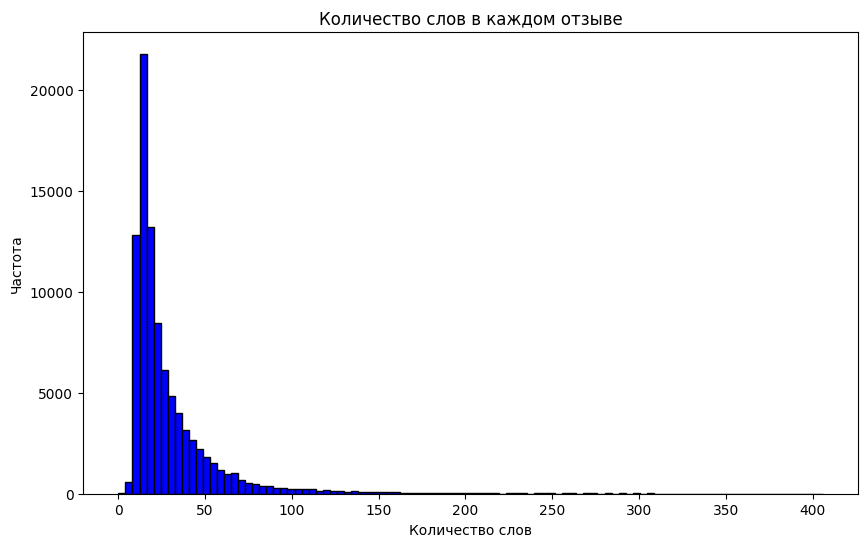

In [24]:
df['word_count'] = df['all_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=100, color='blue', edgecolor='black')
plt.title('Количество слов в каждом отзыве')
plt.xlabel('Количество слов')
plt.ylabel('Частота');

In [25]:
df = df[df.word_count >= 1]

Дополнительно почистим текст и уберем все названия банков, добавив их в список стоп-слов. Для того, чтобы LDA не разбивал обращения на основе этих названий

In [26]:
def clean_bank_name(name):

    name = name.lower()
    name = re.sub(r'\s*банк\s*', '', name)
    name = re.sub(r'[-\s]', '', name)
    return name

unique_bank_names = df.bank_name.unique()
cleaned_bank_names = list(map(clean_bank_name, unique_bank_names))

stopwords_bank_name = set(cleaned_bank_names)

Также уберем слова, которые встречаются почти в каждой категории. Для этого мы прогнали алгоритм на всех категориях, затем нашли в них эти слова, убрали их и обучили алгоритм заново

In [27]:
freq_stopwords = {'банк', 'карта', 'клиент', 'тинькофф', 'совкомбанк', 'пользоваться', 'месяц'}

In [28]:
stopwords = stopwords.union(stopwords_bank_name, freq_stopwords)

stopwords = list(stopwords)

Векторизация

In [29]:
%%time

count_vectorizer = CountVectorizer(max_features=500, ngram_range=(1, 2), stop_words=stopwords, max_df=0.95, min_df=2)
dataset = count_vectorizer.fit_transform(df['all_text'])

lda = LDA(n_components = 12,
          max_iter=10,
          n_jobs=-1,
          learning_method='batch',
          random_state=42)
lda.fit(dataset)

CPU times: user 21.7 s, sys: 1.77 s, total: 23.4 s
Wall time: 7min 4s


LatentDirichletAllocation(n_components=12, n_jobs=-1, random_state=42)

Посмотрим на топ10 слов в каждой из тем, чтобы ее идентифицировать

In [30]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Тема {topic_idx + 1}:", ", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

tf_feature_names = count_vectorizer.get_feature_names_out()
display_topics(lda, tf_feature_names, 10)

Тема 1: сотрудник, обслуживание, вежливый, офис, отделение, помочь, персонал, благодарность, объяснить, отличный
Тема 2: приложение, удобный, кэшбэк, мобильный, мобильный приложение, категория, дебетовый, удобный приложение, кэшбек, нравиться
Тема 3: халва, рассрочка, покупка, кэшбэк, нравиться, обслуживание, удобно, партнёр, бесплатный, магазин
Тема 4: поддержка, проблема, отвечать, отличный, решать, служба, служба поддержка, оперативно, решение, чат
Тема 5: чат, оператор, помочь, приложение, поддержка, помощь, обратиться, ответ, сотрудник, разобраться
Тема 6: выгодный, условие, услуга, обслуживание, предложение, отличный, рекомендовать, удобный, высокий, использование
Тема 7: перевод, комиссия, средство, услуга, вернуть, денежный, оплата, рубль, денежный средство, сумма
Тема 8: кредит, условие, сумма, ипотека, платёж, ставка, заявка, страховка, оформить, договор
Тема 9: дебетовый, оформить, заказать, привезти, курьер, стикер, оформление, доставка, получение, сайт
Тема 10: кредитный, 

Поробуем вручную идентифицировать категории

- 1 обслуживание
- 2 мобильное приложение
- 3 кредитная карта ???
- 4 дистанционное обслуживание
- 5 дистанционное обслуживание
- 6
- 7 переводы (такой категории у нас нет)
- 8 ипотека
- 9 дебетовая карта
- 10 кредитная карта
- 11 вклад
- 12 дистанционное обслуживание

Уменьшим кол-во категорий - отсечем малочисленные, чтобы было проще оценить работу алгоритма

In [31]:
counts = df.review_tag.value_counts()
df = df[df['review_tag'].isin(counts[counts >= 4000].index)]
df.review_tag.value_counts()

,count
review_tag,
Дебетовые карты,38583
Кредитные карты,15508
Обслуживание,11669
Дистанционное обслуживание,8626
Мобильное приложение,4711
Кредиты наличными,4486
Вклады,4396


И уберем тексты, в которых менее 10 слов, так как по такому количеству слов практически невозможно адекватно кластеризовать этот текст

In [32]:
df = df[df.word_count >= 10]

In [33]:
df.shape[0]

86507

От первоначального датасета осталось около 90,5% данных

In [34]:
count_vectorizer = CountVectorizer(max_features=500, ngram_range=(1, 2), stop_words=stopwords, max_df=0.95, min_df=2)
dataset = count_vectorizer.fit_transform(df['all_text'])

lda = LDA(n_components = 7,
          max_iter=10,
          n_jobs=-1,
          learning_method='batch',
          random_state=42)
lda.fit(dataset)

tf_feature_names = count_vectorizer.get_feature_names_out()
display_topics(lda, tf_feature_names, 10)

Тема 1: вклад, процент, счёт, условие, открыть, выгодный, ставка, накопительный, накопительный счёт, остаток
Тема 2: кредитный, дебетовый, оформить, сотрудник, условие, заказать, оформление, привезти, курьер, рассказать
Тема 3: счёт, услуга, средство, сотрудник, уровень, операция, высокий, обслуживание, перевод, обращение
Тема 4: сотрудник, поддержка, обслуживание, проблема, чат, помочь, вежливый, оператор, офис, отвечать
Тема 5: кредит, халва, кредитный, рассрочка, покупка, сумма, платёж, условие, брать, процент
Тема 6: кэшбэк, дебетовый, кэшбек, кешбек, отличный, категория, обслуживание, нравиться, бонус, покупка
Тема 7: приложение, удобный, мобильный, мобильный приложение, перевод, удобный приложение, удобно, понятный, использование, комиссия


Аналогично вручную идентифицируем категории

- 1 вклады
- 2 кредиты наличными
- 3 обслуживание
- 4 дистанционное обслуживание
- 5 кредитная карта
- 6 дебетовая карта
- 7 мобильное приложение


Идентификация не однозначная. Проверим количество обращений в каждой из категорий

In [35]:
pred = lda.transform(dataset)

array([[0.00953418, 0.00953961, 0.00958083, ..., 0.00953665, 0.00954834,
        0.00955211],
       [0.00409953, 0.47230105, 0.2937533 , ..., 0.00410404, 0.1564095 ,
        0.00409611],
       [0.0079413 , 0.63586204, 0.00795234, ..., 0.00794358, 0.00794539,
        0.0079391 ],
       ...,
       [0.91398002, 0.01438927, 0.01429663, ..., 0.01439886, 0.01432836,
        0.01430222],
       [0.01191935, 0.01192433, 0.01196733, ..., 0.39073176, 0.01194095,
        0.37249788],
       [0.03575543, 0.03575819, 0.03581952, ..., 0.03583231, 0.78524107,
        0.03579057]])

Предскажем категории для каждого обращения по максимальной вероятности

In [37]:
df['predictions'] = np.argmax(pred, axis=1)

Сделаем замену в столбце с оригинальными метками

In [36]:
cat_dct = {'Вклады': 0,
           'Кредиты наличными': 1,
           'Обслуживание': 2,
           'Дистанционное обслуживание': 3,
           'Кредитные карты': 4,
           'Дебетовые карты': 5,
           'Мобильное приложение': 6}

In [38]:
df['review_tag_num'] = df.review_tag.replace(cat_dct)

Оценим точность, при условии, что **изначальная пользовательская разметка верная**

In [39]:
review_tag_num = df['review_tag_num']
predictions = df['predictions']

y_true = review_tag_num.astype(int)
y_pred = predictions.astype(int)

accuracy_value = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy_value}")

Accuracy: 0.406313939912377


Для полноты картины посмотрим, по какой вероятности модель назначает категорию

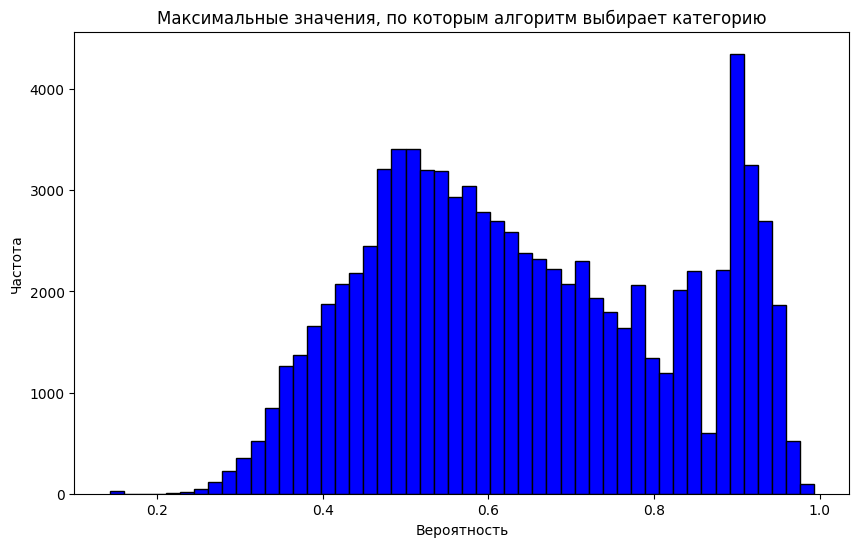

In [40]:
max_values = pred.max(axis=1)

plt.figure(figsize=(10, 6))
plt.hist(max_values, bins=50, color='blue', edgecolor='black')
plt.title('Максимальные значения, по которым алгоритм выбирает категорию')
plt.xlabel('Вероятность')
plt.ylabel('Частота');

И также посмотрим на матрицу ошибок

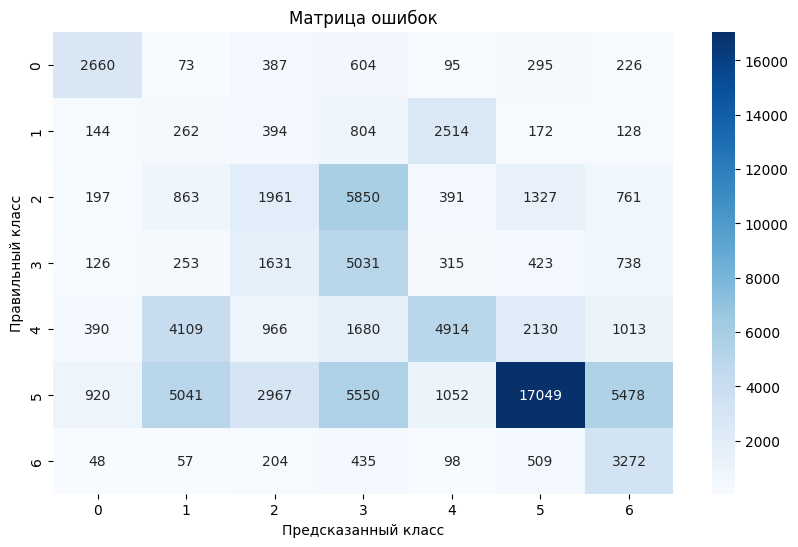

In [41]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Правильный класс');